## Project: Million Playlist Dataset

## A. Data
In this project, you will implement a data processing pipeline for analyzing music playlists. We
will use the Million Playlist Dataset published by Spotify, discussed here: https://www.aicrowd.
com/challenges/spotify-million-playlist-dataset-challenge, and available to download here: https://www.kaggle.com/datasets/himanshuwagh/spotify-million/data.
The dataset contains one million playlists, where each playlist contains information about the playlist
itself (e.g., playlist title, duration) and each track it contains (e.g., track id, artist id, track name,
duration). The dataset was used as part of a “playlist continuation” challenge: given a playlist name
and a few tracks, predict which other tracks would fit best with that playlist.

## B. Tasks
In this project, you are asked to address the following tasks.
1. Present your approach to handling this big dataset. Given that the dataset is big, at about 35 GB,
you are not expected to be able to process all of it. Ideally, of course, you should have a solution
that scales to the whole dataset. Describe the approach you took and all the alternatives you
considered.
2. Present some interesting statistical/aggregate information about the dataset. Explain how you
derived the presented information.
3. Propose a definition of similarity between tracks. Specifically, given two tracks, their similarity
is a score from 0 to 1, where 0 indicates that the two tracks are not similar at all, and 1 indicates
that the two tracks are identical. Design a method to compute those similarity scores using the
dataset. Discuss the implementation and give some examples.
4. Propose a definition of similarity (score ranging from 0 to 1) between playlists. Design a method
to compute this similarity score using the dataset. Discuss the implementation and give some
examples.
5. Propose a method to solve the “playlist continuation” challenge. Discuss the implementation
and give some examples.
You should write the code in Python, and you are free to use the tools and frameworks (e.g., Spark,
Dask) that we have discussed in this course as well as others.


## Our approach
 1. 1st step : load the first slice and explore how it look likes (task 0 - setup)
 2. 2nd step : Generate and load a random sample df among the slices (task 1)
 3. 3rd step : Derive all analytics in a main function to run on the sampled df (task 2)
 4. 4th step : Build and define the track_similarity_score function based on analytics and sampled df (task 3)
 4. 5th step : Build and define the playlist_similarity_score function based on analytics and sampled df (task 4)
 5. 6th step : Build and define the "next track" algorithm based on the similarity_score (task 5)
 6. 7th step : To scale => generate the whole df containing all slices then re-run step 3-5 on this df. Eventually compare analytics of sample_df and final_df to assess robustness and adjust 4th-6th steps if needed. (Only if able to compute the final_df)

## Task 0 : Initialization
0. Create venv (temp env for the project with used packages etc, can be removed after project) with prompt: 
    conda create venv --name pyspark_env python=3.9 pyspark openjdk=17 -c conda-forge
    conda activate pyspark_env
1. Note to self : solving issues setting up sparks : <br>
- set up new conda envs forcing python 3.9 <br>
- set up java-jdk forcing v.17 <br>
- set up winutils.exe in depository "C:\hadoop\bin" <br>
- Add setup settings to the session <br>
- After conda activate pyspark_env => install required packages : 
- conda install matplotlib <br>
- conda install ipykernel <br>
2. Get the data : <br>
- Downloaded the dataset from kaggle and unzipped it in my G-Drive.
- For faster computin, transfered the dataset to local disk c:\\

In [1]:
import os
import sys
from pyspark.sql import SparkSession

# --- Windows/Local Spark Fix ---
# the worker processes use the exact same Python environment as the notebook.
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

# Ensure local temp directory exists for Spark
_tmp = os.environ.get("SPARK_LOCAL_DIR", "C:/temp/spark")
try:
    os.makedirs(_tmp, exist_ok=True)
except Exception:
    _tmp = "C:/temp/spark"
    os.makedirs(_tmp, exist_ok=True)

# Stable local Spark configuration
spark = (
    SparkSession.builder
    .master("local[*]")
    .appName("MPD_Project")
    # Fix for "Python worker failed to connect back" on Windows
    .config("spark.driver.bindAddress", "127.0.0.1")
    .config("spark.driver.host", "127.0.0.1")
    # Memory and temp settings
    .config("spark.driver.memory", "4g")
    .config("spark.executor.memory", "2g")
    .config("spark.local.dir", _tmp)
    # Disable dynamic allocation / speculative tasks for Windows stability
    .config("spark.dynamicAllocation.enabled", "false")
    .config("spark.speculation", "false")
    # Reduce shuffle partitions for local workloads
    .config("spark.sql.shuffle.partitions", "8")
    # Reduce logging verbosity
    .config("spark.ui.showConsoleProgress", "false")
    .config("spark.eventLog.enabled", "false")
    .getOrCreate()
)

# Set log level to WARN to reduce console output
spark.sparkContext.setLogLevel("WARN")

# Quick ping to ensure session is usable
_ = spark.range(1).count()
print(f"✓ Spark session initialized (Python: {sys.executable})")

✓ Spark session initialized (Python: c:\Users\nrnor\miniconda3\envs\pyspark_env\python.exe)


## Task 0a : load explore_df (1th slice)

In [2]:
from pyspark.sql.functions import col, explode

BASE_FOLDER = r"C:\Users\nrnor\Documents\Master BGDA\INFO-H600\Project\kaggle\data"
file_path = os.path.join(BASE_FOLDER, "mpd.slice.0-999.json")

if os.path.exists(file_path):
    df_raw = spark.read.option("multiline", True).json(file_path)
    
    # EXPLORATION PHASE: Load ALL available variables to assess their utility
    explore_df = (
        df_raw
        .select(explode("playlists").alias("playlist"))
        .select(
            # Playlist Metadata
            col("playlist.pid").alias("playlist_id"),
            col("playlist.name").alias("playlist_name"),
            col("playlist.description").alias("playlist_description"),
            col("playlist.num_followers").alias("num_followers"),
            col("playlist.num_edits").alias("num_edits"),
            col("playlist.modified_at").alias("modified_at"),
            col("playlist.collaborative").alias("is_collaborative"),
            col("playlist.duration_ms").alias("playlist_duration_ms"),
            
            # Track Metadata (Exploded)
            explode("playlist.tracks").alias("track")
        )
        .select(
            # Keep all playlist info
            col("playlist_id"),
            col("playlist_name"),
            col("playlist_description"),
            col("num_followers"),
            col("num_edits"),
            col("modified_at"),
            col("is_collaborative"),
            col("playlist_duration_ms"),
            
            # Keep all track info
            col("track.pos").alias("track_position"),
            col("track.track_name").alias("track_name"),
            col("track.track_uri").alias("track_uri"),
            col("track.artist_name").alias("artist_name"),
            col("track.artist_uri").alias("artist_uri"),
            col("track.album_name").alias("album_name"),
            col("track.album_uri").alias("album_uri"),
            col("track.duration_ms").alias("duration_ms")
        )
    )

    print(f"✓ Dataset loaded (FULL SCHEMA): {explore_df.count()} tracks")
    explore_df.printSchema()
    explore_df.show(2, truncate=False, vertical=True)
else:
    print(f"ERROR: File not found at {file_path}")

✓ Dataset loaded (FULL SCHEMA): 67503 tracks
root
 |-- playlist_id: long (nullable = true)
 |-- playlist_name: string (nullable = true)
 |-- playlist_description: string (nullable = true)
 |-- num_followers: long (nullable = true)
 |-- num_edits: long (nullable = true)
 |-- modified_at: long (nullable = true)
 |-- is_collaborative: string (nullable = true)
 |-- playlist_duration_ms: long (nullable = true)
 |-- track_position: long (nullable = true)
 |-- track_name: string (nullable = true)
 |-- track_uri: string (nullable = true)
 |-- artist_name: string (nullable = true)
 |-- artist_uri: string (nullable = true)
 |-- album_name: string (nullable = true)
 |-- album_uri: string (nullable = true)
 |-- duration_ms: long (nullable = true)

-RECORD 0----------------------------------------------------------
 playlist_id          | 0                                          
 playlist_name        | Throwbacks                                 
 playlist_description | NULL                      

## Task : 0b visualize explore_df

=== Dataset Overview ===
Total tracks: 67,503
Total tracks: 67,503
Unique playlists: 1,000
Unique playlists: 1,000
Unique artists: 9,722
Unique artists: 9,722
Unique tracks: 34,250

=== Top 10 Artists ===
Unique tracks: 34,250

=== Top 10 Artists ===
+--------------+-----------+
|artist_name   |track_count|
+--------------+-----------+
|Drake         |939        |
|Kanye West    |415        |
|Kendrick Lamar|385        |
|Rihanna       |350        |
|Eminem        |332        |
|The Weeknd    |296        |
|Lil Uzi Vert  |292        |
|Ed Sheeran    |285        |
|Future        |265        |
|Chris Brown   |259        |
+--------------+-----------+


=== Playlist Size Stats ===
+--------------+-----------+
|artist_name   |track_count|
+--------------+-----------+
|Drake         |939        |
|Kanye West    |415        |
|Kendrick Lamar|385        |
|Rihanna       |350        |
|Eminem        |332        |
|The Weeknd    |296        |
|Lil Uzi Vert  |292        |
|Ed Sheeran    |285    

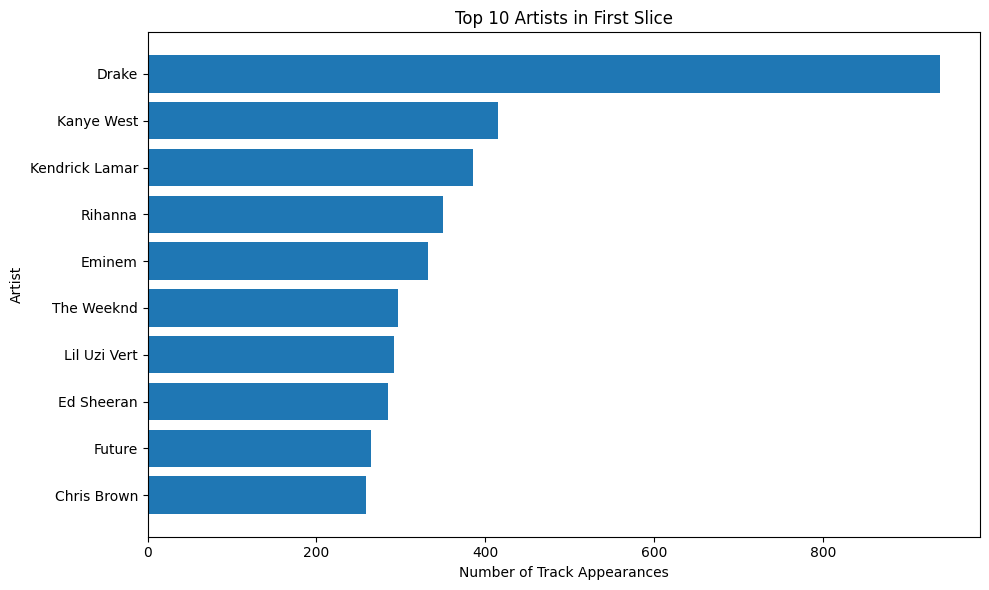

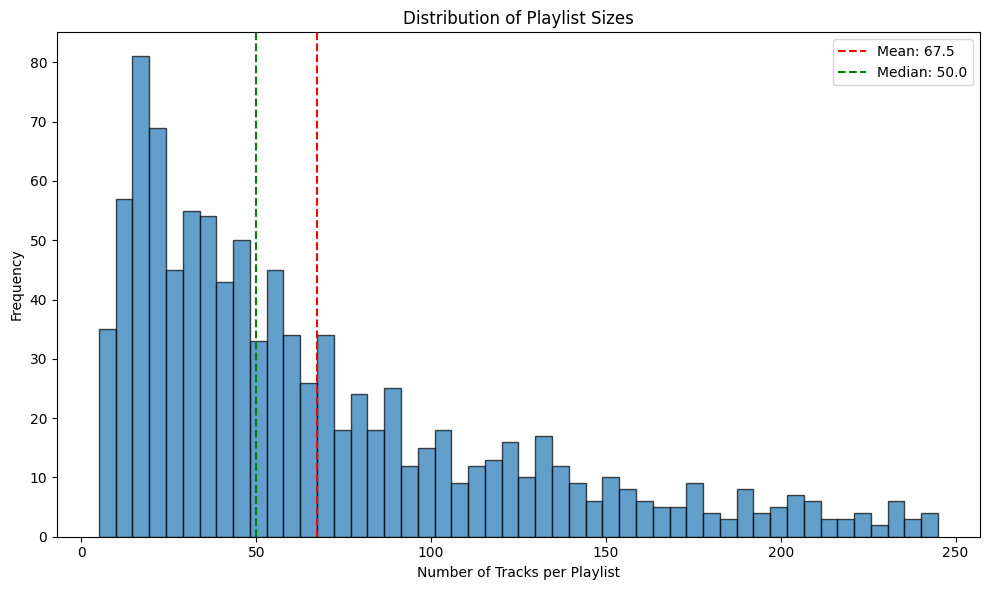


=== Track Duration Stats (ms) ===
+-------+------------------+
|summary|       duration_ms|
+-------+------------------+
|  count|             67503|
|   mean|233183.90283394812|
| stddev| 64552.34264440953|
|    min|                 0|
|    max|           2424189|
+-------+------------------+

+-------+------------------+
|summary|       duration_ms|
+-------+------------------+
|  count|             67503|
|   mean|233183.90283394812|
| stddev| 64552.34264440953|
|    min|                 0|
|    max|           2424189|
+-------+------------------+



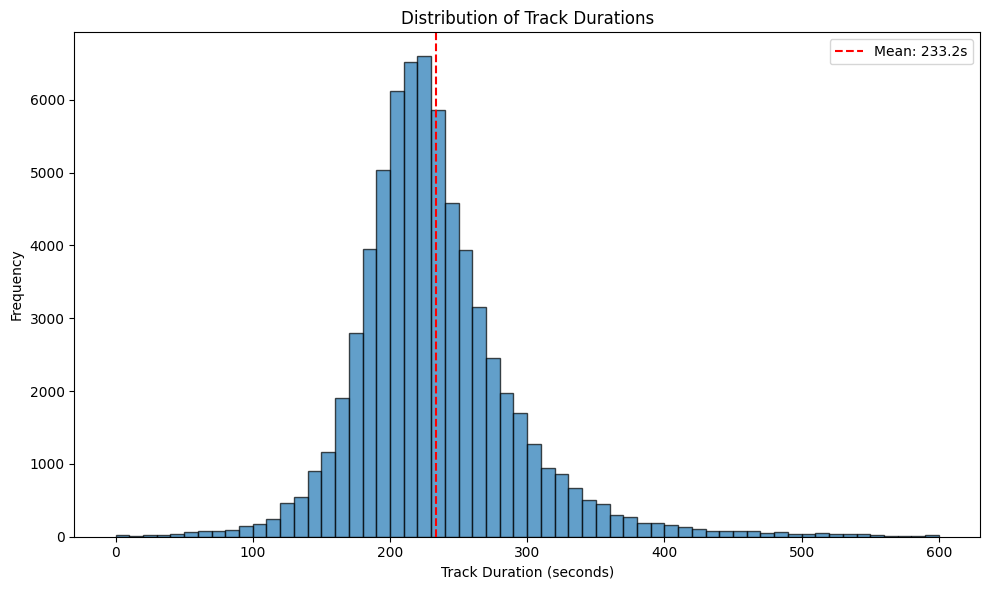

In [3]:
# Quick exploration & visualization of explore_df (first slice)
from pyspark.sql.functions import count, avg, col
import matplotlib.pyplot as plt
import pandas as pd
# Basic stats
print("=== Dataset Overview ===")
print(f"Total tracks: {explore_df.count():,}")
print(f"Unique playlists: {explore_df.select('playlist_id').distinct().count():,}")
print(f"Unique artists: {explore_df.select('artist_name').distinct().count():,}")
print(f"Unique tracks: {explore_df.select('track_name', 'artist_name').distinct().count():,}")

# Top artists by frequency
print("\n=== Top 10 Artists ===")

top_artists = explore_df.groupBy("artist_name") \
    .agg(count("*").alias("track_count")) \
    .orderBy(col("track_count").desc()) \
    .limit(10)
top_artists.show(truncate=False)

# Playlist size distribution
print("\n=== Playlist Size Stats ===")
playlist_sizes = explore_df.groupBy("playlist_id") \
    .agg(count("*").alias("num_tracks"))
playlist_sizes.describe("num_tracks").show()

# Top artists bar chart
top_artists_pd = top_artists.toPandas()
plt.figure(figsize=(10, 6))
plt.barh(top_artists_pd['artist_name'], top_artists_pd['track_count'])
plt.xlabel('Number of Track Appearances')
plt.ylabel('Artist')
plt.title('Top 10 Artists in First Slice')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Playlist size distribution histogram
playlist_sizes_pd = playlist_sizes.toPandas()
plt.figure(figsize=(10, 6))
plt.hist(playlist_sizes_pd['num_tracks'], bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Number of Tracks per Playlist')
plt.ylabel('Frequency')
plt.title('Distribution of Playlist Sizes')
plt.axvline(playlist_sizes_pd['num_tracks'].mean(), color='red', linestyle='--', label=f"Mean: {playlist_sizes_pd['num_tracks'].mean():.1f}")
plt.axvline(playlist_sizes_pd['num_tracks'].median(), color='green', linestyle='--', label=f"Median: {playlist_sizes_pd['num_tracks'].median():.1f}")
plt.legend()
plt.tight_layout()
plt.show()

# Track duration analysis
print("\n=== Track Duration Stats (ms) ===")
explore_df.select("duration_ms").describe().show()

duration_pd = explore_df.select("duration_ms").toPandas()
duration_pd['duration_sec'] = duration_pd['duration_ms'] / 1000

plt.figure(figsize=(10, 6))
plt.hist(duration_pd['duration_sec'], bins=60, range=(0, 600), edgecolor='black', alpha=0.7)
plt.xlabel('Track Duration (seconds)')
plt.ylabel('Frequency')
plt.title('Distribution of Track Durations')
plt.axvline(duration_pd['duration_sec'].mean(), color='red', linestyle='--', label=f"Mean: {duration_pd['duration_sec'].mean():.1f}s")
plt.legend()
plt.tight_layout()
plt.show()

## Task 1 : load sample_df
> Reflexion : 
>> How can we handle the dataset to minimize computing time and induced bias through sampling <br>
>> What do we know of the slices ? Are they compoped of random playlist or is there any sorting/grouping ? <br>
> 1. Method 1 : Simply select every nth slice (determinist)
> 2. Method 2 : Select n slices randomly
> 3. Method 3 : Select n random slices then k random playlists

> **Variable Selection (based on Task 0 analysis):**
> - **Dropped:** `playlist_description` (98% missing), `num_followers` (mostly 1 - only 16 > 1), `num_edits`, `modified_at`, `is_collaborative` (only 2% true).
> - **Kept:** `track_uri`, `artist_uri`, `album_uri` (for identification), `pos`, `duration_ms`.

## Task 1a : build helpers for various sampling & loading strategies

In [4]:
# --- Helpers: slice listing, reading, playlist/track transforms ---
import glob
import random
from pyspark.sql import functions as F

def list_slices(base_folder, pattern="mpd.slice.*.json"):
    """Return sorted list of slice file paths."""
    return sorted(glob.glob(f"{base_folder}/{pattern}"))

def read_slices(slices):
    """Read one or many JSON slice files into a Spark DataFrame."""
    return spark.read.option("multiline", "true").json(slices)

def playlists_df_from_raw(df_raw):
    """Explode raw df into one row per playlist, keeping nested tracks."""
    return df_raw.select(F.explode("playlists").alias("playlist")) \
                 .select(
                     F.col("playlist.pid").alias("playlist_id"),
                     F.col("playlist.name").alias("playlist_name"),
                     F.col("playlist.tracks").alias("tracks")
                 )

def tracks_df_from_playlists(playlists_df):
    """Explode playlist-level df into one row per track (tracks-level)."""
    return playlists_df.select(
            F.col("playlist_id"), 
            F.col("playlist_name"), 
            F.explode("tracks").alias("track")
        ).select(
           "playlist_id",
           "playlist_name",
           F.col("track.pos").alias("track_position"),
           F.col("track.track_name").alias("track_name"),
           F.col("track.track_uri").alias("track_uri"),
           F.col("track.artist_name").alias("artist_name"),
           F.col("track.artist_uri").alias("artist_uri"),
           F.col("track.album_name").alias("album_name"),
           F.col("track.album_uri").alias("album_uri"),
           F.col("track.duration_ms").alias("duration_ms")
       )

def random_choose_slices(slice_files, k, seed=42):
    random.seed(seed)
    return random.sample(slice_files, min(k, len(slice_files)))

#### Method 1 : Select every nth slices (determinist)

In [5]:
# Method 1 : Deterministic every-nth slices sampling

# Parameters
NTH = 10  # take every NTH slice
BASE_FOLDER = r"C:\Users\nrnor\Documents\Master BGDA\INFO-H600\Project\kaggle\data"

slice_files = list_slices(BASE_FOLDER)
sample_files = slice_files[::NTH]
print(f"Method 1: taking every {NTH}th slice → {len(sample_files)} files")

# Read and flatten to playlist-level
df_raw = read_slices(sample_files)
playlists_df = playlists_df_from_raw(df_raw)

# Flatten to tracks-level and cache
M1_sample_df = tracks_df_from_playlists(playlists_df).cache()

# Minimal diagnostic
print(f"M1_sample_df ready (tracks-level). Example rows:")
M1_sample_df.show(5, truncate=False)


Method 1: taking every 10th slice → 100 files
M1_sample_df ready (tracks-level). Example rows:
M1_sample_df ready (tracks-level). Example rows:
+-----------+-------------+--------------+-----------------------------+------------------------------------+--------------------+-------------------------------------+--------------------------------+------------------------------------+-----------+
|playlist_id|playlist_name|track_position|track_name                   |track_uri                           |artist_name         |artist_uri                           |album_name                      |album_uri                           |duration_ms|
+-----------+-------------+--------------+-----------------------------+------------------------------------+--------------------+-------------------------------------+--------------------------------+------------------------------------+-----------+
|675000     |Light        |0             |Union - Groove Mix           |spotify:track:3Ko5oOHlziMVcfr5N

#### Method 2 : Random slice

In [6]:
# Method 2 : Random slices sampling

# Parameters
k = 100   # number of slices to pick
SEED = 42
BASE_FOLDER = r"C:\Users\nrnor\Documents\Master BGDA\INFO-H600\Project\kaggle\data"

# List slices and choose randomly
slice_files = list_slices(BASE_FOLDER)
chosen = random_choose_slices(slice_files, k, seed=SEED)
print(f"Chosen {len(chosen)} slices (out of {len(slice_files)})")

# Read chosen slices and flatten to playlist-level
df_raw = read_slices(chosen)
playlists_df = playlists_df_from_raw(df_raw)

# Flatten to tracks-level and cache
M2_sample_df = tracks_df_from_playlists(playlists_df).cache()

# Minimal diagnostic
print("M2_sample_df ready (tracks-level). Example rows:")
M2_sample_df.show(5, truncate=False)

Chosen 100 slices (out of 1000)
M2_sample_df ready (tracks-level). Example rows:
M2_sample_df ready (tracks-level). Example rows:
+-----------+-------------+--------------+-------------------------------+------------------------------------+-----------------+-------------------------------------+-------------------------------+------------------------------------+-----------+
|playlist_id|playlist_name|track_position|track_name                     |track_uri                           |artist_name      |artist_uri                           |album_name                     |album_uri                           |duration_ms|
+-----------+-------------+--------------+-------------------------------+------------------------------------+-----------------+-------------------------------------+-------------------------------+------------------------------------+-----------+
|300000     |April 2017   |0             |Cold Heart Killer              |spotify:track:1IPfImi6ZtZlZo90xPigfM|Lia Marie Jo

#### Method 3 : Random slice + random playlist

In [7]:
# Method 3 : Random slices + random playlists sampling

# Parameters
K_SLICES = 200   # number of slices to randomly load
N_PLAYLISTS = 100000  # target playlists
SEED = 42
BASE_FOLDER = r"C:\Users\nrnor\Documents\Master BGDA\INFO-H600\Project\kaggle\data"

slice_files = list_slices(BASE_FOLDER)
chosen = random_choose_slices(slice_files, K_SLICES, seed=SEED)
print(f"Method 3: chosen {len(chosen)} random slices")

# Read chosen slices and flatten to playlists-level
df_raw = read_slices(chosen)
playlists_df = playlists_df_from_raw(df_raw)

# Use sample() instead of orderBy to avoid shuffle issues
sample_fraction = min(1.0, N_PLAYLISTS / playlists_df.count() * 1.2)  # 20% buffer
sample_playlists = playlists_df.sample(fraction=sample_fraction, seed=SEED).limit(N_PLAYLISTS)

# Flatten to tracks-level and cache
M3_sample_df = tracks_df_from_playlists(sample_playlists).cache()

# Minimal diagnostics
print("M3_sample_df ready (tracks-level).")
print(f"Total playlists sampled: {M3_sample_df.select('playlist_id').distinct().count()}")
print(f"Total tracks: {M3_sample_df.count()}")


Method 3: chosen 200 random slices
M3_sample_df ready (tracks-level).
M3_sample_df ready (tracks-level).
Total playlists sampled: 100000
Total tracks: 6689682
Total playlists sampled: 100000
Total tracks: 6689682


#### Compare samples

SAMPLING METHODS COMPARISON

                         Method  Total Tracks  Unique Playlists  Unique Artists  Unique Tracks  Avg Playlist Size
          M1 (Every 10th slice)       6633713            100000          108537         669453           66.33713
         M2 (100 random slices)       6624113            100000          108479         671849           66.24113
M3 (200 slices, 100k playlists)       6689682            100000          108113         673189           66.89682

                         Method  Total Tracks  Unique Playlists  Unique Artists  Unique Tracks  Avg Playlist Size
          M1 (Every 10th slice)       6633713            100000          108537         669453           66.33713
         M2 (100 random slices)       6624113            100000          108479         671849           66.24113
M3 (200 slices, 100k playlists)       6689682            100000          108113         673189           66.89682


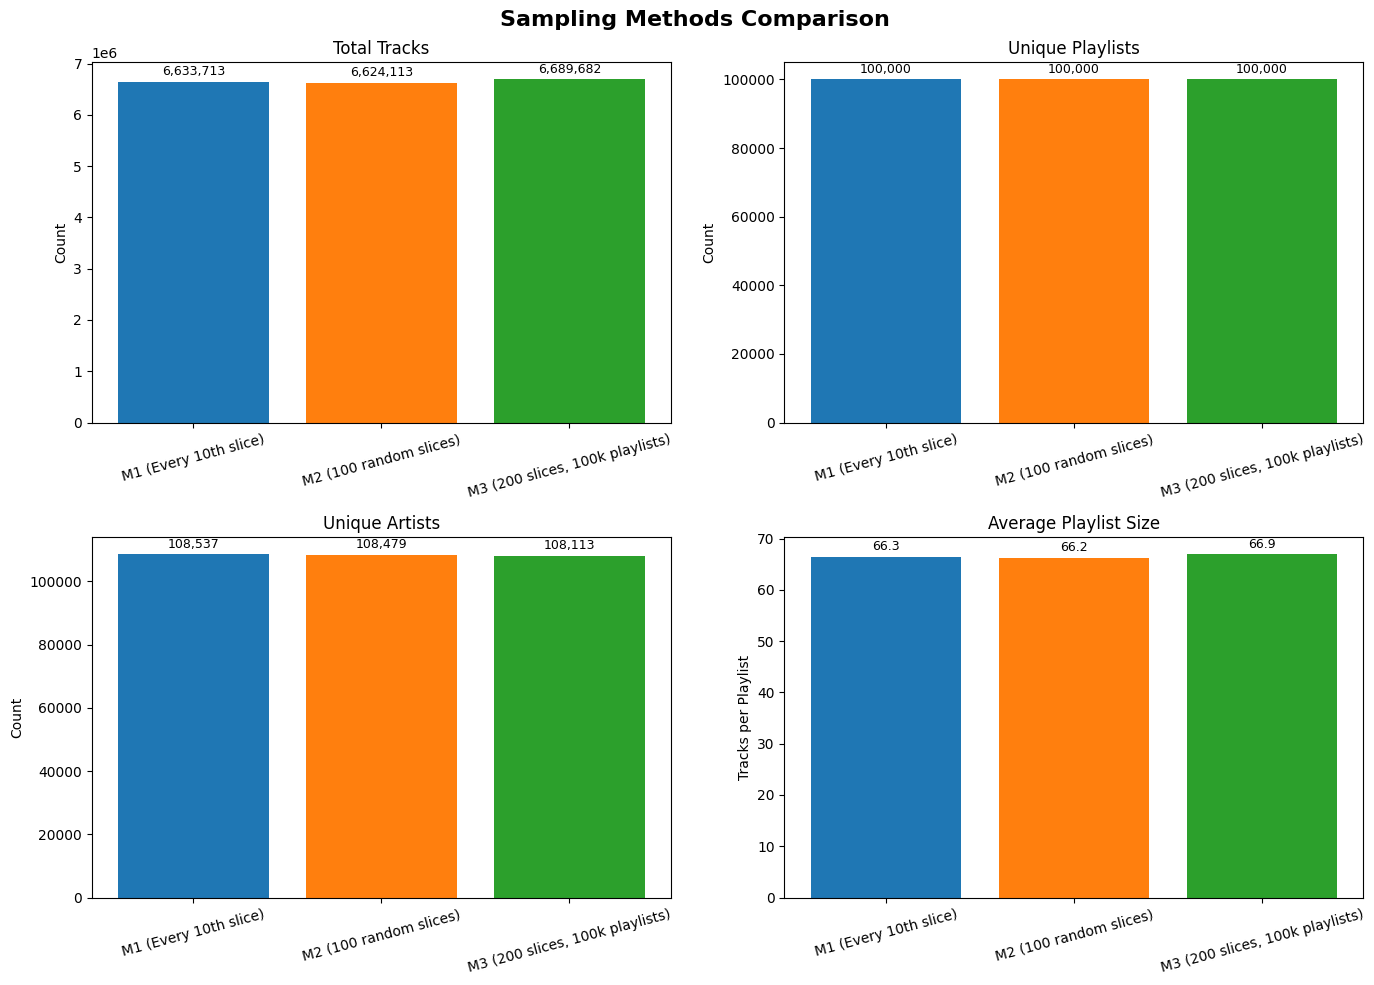


COVERAGE ANALYSIS (vs. Complete Dataset)

Dataset totals: 1,000,000 playlists | 295,860 artists | 2,262,292 tracks

M1 (Every 10th slice):
  Playlists: 100,000 (10.00%)
  Artists: 108,537 (36.69%)
  Tracks: 6,633,713 (9.999%)
  Diversity: 16.4 artists per 1000 tracks

M2 (100 random slices):
  Playlists: 100,000 (10.00%)
  Artists: 108,479 (36.67%)
  Tracks: 6,624,113 (9.984%)
  Diversity: 16.4 artists per 1000 tracks

M3 (200 slices, 100k playlists):
  Playlists: 100,000 (10.00%)
  Artists: 108,113 (36.54%)
  Tracks: 6,689,682 (10.083%)
  Diversity: 16.2 artists per 1000 tracks

✓ Comparison complete. Method recommendations:
Given the similarities in coverage for the same # playlists, we'll use sampling method M3 for our experiments even though its computing time was a bit longer initially.


In [8]:
# Quick comparison of sampling methods (M1, M2, M3)
from pyspark.sql.functions import count, countDistinct, avg, col

print("=" * 80)
print("SAMPLING METHODS COMPARISON")
print("=" * 80)

# Define samples to compare
samples = [
    ("M1 (Every 10th slice)", M1_sample_df),
    ("M2 (100 random slices)", M2_sample_df),
    ("M3 (200 slices, 100k playlists)", M3_sample_df)
]

# Collect metrics for each sample
comparison_data = []
for name, df in samples:
    metrics = {
        "Method": name,
        "Total Tracks": df.count(),
        "Unique Playlists": df.select("playlist_id").distinct().count(),
        "Unique Artists": df.select("artist_name").distinct().count(),
        "Unique Tracks": df.select("track_name", "artist_name").distinct().count(),
        "Avg Playlist Size": df.groupBy("playlist_id").agg(count("*").alias("size")).agg(avg("size")).collect()[0][0]
    }
    comparison_data.append(metrics)

# Display comparison table
import pandas as pd
comparison_df = pd.DataFrame(comparison_data)
print("\n" + comparison_df.to_string(index=False))

# Visual comparison
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Sampling Methods Comparison', fontsize=16, fontweight='bold')

# Total tracks comparison
ax = axes[0, 0]
ax.bar(comparison_df['Method'], comparison_df['Total Tracks'], color=['#1f77b4', '#ff7f0e', '#2ca02c'])
ax.set_ylabel('Count')
ax.set_title('Total Tracks')
ax.tick_params(axis='x', rotation=15)
for i, v in enumerate(comparison_df['Total Tracks']):
    ax.text(i, v + max(comparison_df['Total Tracks'])*0.02, f"{v:,}", ha='center', fontsize=9)

# Unique playlists comparison
ax = axes[0, 1]
ax.bar(comparison_df['Method'], comparison_df['Unique Playlists'], color=['#1f77b4', '#ff7f0e', '#2ca02c'])
ax.set_ylabel('Count')
ax.set_title('Unique Playlists')
ax.tick_params(axis='x', rotation=15)
for i, v in enumerate(comparison_df['Unique Playlists']):
    ax.text(i, v + max(comparison_df['Unique Playlists'])*0.02, f"{v:,}", ha='center', fontsize=9)

# Unique artists comparison
ax = axes[1, 0]
ax.bar(comparison_df['Method'], comparison_df['Unique Artists'], color=['#1f77b4', '#ff7f0e', '#2ca02c'])
ax.set_ylabel('Count')
ax.set_title('Unique Artists')
ax.tick_params(axis='x', rotation=15)
for i, v in enumerate(comparison_df['Unique Artists']):
    ax.text(i, v + max(comparison_df['Unique Artists'])*0.02, f"{v:,}", ha='center', fontsize=9)

# Average playlist size comparison
ax = axes[1, 1]
ax.bar(comparison_df['Method'], comparison_df['Avg Playlist Size'], color=['#1f77b4', '#ff7f0e', '#2ca02c'])
ax.set_ylabel('Tracks per Playlist')
ax.set_title('Average Playlist Size')
ax.tick_params(axis='x', rotation=15)
for i, v in enumerate(comparison_df['Avg Playlist Size']):
    ax.text(i, v + max(comparison_df['Avg Playlist Size'])*0.02, f"{v:.1f}", ha='center', fontsize=9)

plt.tight_layout()
plt.show()

# True coverage analysis (values from kaggle/stats.txt)
TOTAL_PLAYLISTS = 1_000_000
TOTAL_TRACKS = 66_346_428
TOTAL_UNIQUE_TRACKS = 2_262_292
TOTAL_UNIQUE_ARTISTS = 295_860
TOTAL_UNIQUE_ALBUMS = 734_684

print("\n" + "=" * 80)
print("COVERAGE ANALYSIS (vs. Complete Dataset)")
print("=" * 80)
print(f"\nDataset totals: {TOTAL_PLAYLISTS:,} playlists | {TOTAL_UNIQUE_ARTISTS:,} artists | {TOTAL_UNIQUE_TRACKS:,} tracks")

for i, row in comparison_df.iterrows():
    print(f"\n{row['Method']}:")
    print(f"  Playlists: {row['Unique Playlists']:,} ({row['Unique Playlists']/TOTAL_PLAYLISTS*100:.2f}%)")
    print(f"  Artists: {row['Unique Artists']:,} ({row['Unique Artists']/TOTAL_UNIQUE_ARTISTS*100:.2f}%)")
    print(f"  Tracks: {row['Total Tracks']:,} ({row['Total Tracks']/TOTAL_TRACKS*100:.3f}%)")
    diversity_ratio = (row['Unique Artists'] / row['Total Tracks']) * 1000
    print(f"  Diversity: {diversity_ratio:.1f} artists per 1000 tracks")

print("\n✓ Comparison complete. Method recommendations:")
print("Given the similarities in coverage for the same # playlists, we'll use sampling method M3 for our experiments even though its computing time was a bit longer initially.")

## Task 2 : define main analysis (to run on samples)

In [9]:
## block for task 2

## Task 3 : define track similiarity scoring function 

#### Approach: Hybrid Similarity Score
To quantify the similarity between two tracks ($t_1, t_2$), we propose a **Weighted Hybrid Score** that combines **User Behavior (Context)** and **Metadata (Content)**.

$$ Score(t_1, t_2) = \alpha \cdot Sim_{context}(t_1, t_2) + (1 - \alpha) \cdot Sim_{content}(t_1, t_2) $$

We chose $\alpha = 0.7$ to prioritize user behavior, as co-occurrence in playlists is a stronger signal of "vibe" similarity than raw metadata.

##### 1. Context Similarity (Jaccard Index)
We measure how often two tracks appear together in the same playlists relative to their total appearances. This normalizes for popularity (avoiding the "Drake effect" where popular tracks co-occur with everything).

$$ J(t_1, t_2) = \frac{|P(t_1) \cap P(t_2)|}{|P(t_1) \cup P(t_2)|} $$

Where $P(t)$ is the set of Playlist IDs containing track $t$.

##### 2. Content Similarity (Metadata)
We use a simple rule-based score to boost tracks that share metadata attributes. This helps with the "Cold Start" problem for rare tracks.
*   **Same Artist:** +0.5
*   **Same Album:** +0.3
*   *(Normalized to range 0-1)*

##### 3. Implementation Strategy
Computing $N^2$ pairs is impossible for 2M+ tracks. We use an **Inverted Index** approach:
1.  **Build Profiles (`build_track_profiles`):** We aggregate the dataset once to create a global `track_profiles` DataFrame. This acts as a lookup table mapping `Track_URI -> {Set<Playlist_IDs>, Artist_URI, Album_URI}`.
2.  **On-Demand Calculation (`calculate_track_score`):** The scoring function takes two Track URIs, retrieves their profiles from the global DataFrame, and computes the score instantly. This keeps the function signature simple and efficient.

In [10]:
from pyspark.sql import functions as F

# 1. Define Profile Builder
def build_track_profiles(df):
    """
    Aggregates track data to create profiles containing:
    - Context: List of playlists it appears in
    - Content: Artist URI, Album URI, Track Name, Artist Name
    """
    return df.groupBy("track_uri").agg(
        F.collect_set("playlist_id").alias("playlist_ids"),
        F.first("artist_uri").alias("artist_uri"),
        F.first("album_uri").alias("album_uri"),
        F.first("track_name").alias("track_name"),
        F.first("artist_name").alias("artist_name")
    ).cache()

# 2. Build and Store Profiles
track_profiles = build_track_profiles(M3_sample_df)
print(f"Track profiles built for {track_profiles.count()} unique tracks.")

# 3. Define Scoring Function
def calculate_track_score(track1_uri, track2_uri):
    """
    Calculates similarity score between two tracks using the global track_profiles DataFrame.
    Returns ONLY the final weighted score (float).
    """
    # A. Fetch Profiles
    # We look up both tracks in the global track_profiles DataFrame
    rows = track_profiles.filter(F.col("track_uri").isin([track1_uri, track2_uri])).collect()
    
    if len(rows) < 2:
        # If we can't find both tracks (or if same track passed and only 1 row returned), return 0
        if len(rows) == 1 and track1_uri == track2_uri:
            p1 = rows[0]; p2 = rows[0]
        else:
            return 0.0
    else:
        p1 = next(r for r in rows if r["track_uri"] == track1_uri)
        p2 = next(r for r in rows if r["track_uri"] == track2_uri)

    # B. Context Similarity (Jaccard)
    set1 = set(p1["playlist_ids"])
    set2 = set(p2["playlist_ids"])
    
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    jaccard_score = intersection / union if union > 0 else 0.0
    
    # C. Content Similarity (Metadata)
    meta_score = 0.0
    if p1["artist_uri"] == p2["artist_uri"]:
        meta_score += 0.5
    if p1["album_uri"] == p2["album_uri"]:
        meta_score += 0.3
    
    # D. Weighted Hybrid Score
    # Weights: 70% Jaccard, 30% Metadata (normalized)
    hybrid_score = (0.7 * jaccard_score) + (0.3 * (meta_score / 0.8))
    
    return round(hybrid_score, 4)

Track profiles built for 687833 unique tracks.


### Examples for track similarity

In [11]:
# Test with two tracks
sample_tracks = M3_sample_df.limit(5).collect()
t1_uri = sample_tracks[0]["track_uri"]
t2_uri = sample_tracks[1]["track_uri"]

# Calculate score directly using URIs (uses global track_profiles)
score = calculate_track_score(t1_uri, t2_uri)

# Fetch details just for printing the names in the example
p1 = track_profiles.filter(F.col("track_uri") == t1_uri).first()
p2 = track_profiles.filter(F.col("track_uri") == t2_uri).first()

# Manually calculate context info for display
set1 = set(p1["playlist_ids"])
set2 = set(p2["playlist_ids"])
common = len(set1.intersection(set2))
total_unique = len(set1.union(set2))

print(f"Track 1: {p1['artist_name']} - {p1['track_name']}")
print(f"Track 2: {p2['artist_name']} - {p2['track_name']}")
print(f"Similarity Score: {score}")
print(f"Context Info: Appears in {len(set1)} & {len(set2)} playlists. Common: {common}. Union (total_unique): {total_unique}")

Track 1: Foxygen - San Francisco
Track 2: Beach House - Space Song
Similarity Score: 0.0107
Context Info: Appears in 114 & 283 playlists. Common: 6. Union (total_unique): 391


## Task 4 : define playlist similarity scoring function

#### Approach: Hybrid Playlist Similarity
To quantify the similarity between two playlists ($P_1, P_2$), we use a weighted combination of **Exact Track Matching** and **Artist Overlap**.

$$ Score(P_1, P_2) = w_t \cdot J(Tracks_1, Tracks_2) + w_a \cdot J(Artists_1, Artists_2) $$

We chose $w_t = 0.7$ and $w_a = 0.3$ to prioritize exact content matches while allowing for "genre" similarity via artists.

##### 1. Track Overlap (Jaccard)
Measures how many exact tracks the playlists share.
$$ J(Tracks_1, Tracks_2) = \frac{|T_1 \cap T_2|}{|T_1 \cup T_2|} $$

##### 2. Artist Overlap (Jaccard)
Measures how many artists they share. This captures "genre" or "vibe" similarity even if the specific songs differ.
$$ J(Artists_1, Artists_2) = \frac{|A_1 \cap A_2|}{|A_1 \cup A_2|} $$

##### 3. Implementation Strategy
Similar to the track similarity approach, we optimize for lookups:
1.  **Build Profiles (`build_playlist_profiles`):** We aggregate the dataset to create a global `playlist_profiles` DataFrame. This maps `Playlist_ID -> {Set<Track_URIs>, Set<Artist_URIs>}`.
2.  **On-Demand Calculation (`calculate_playlist_score`):** The scoring function takes two Playlist IDs, retrieves their profiles from the global DataFrame, and computes the weighted Jaccard score. This ensures the core logic remains simple and fast.

In [12]:
from pyspark.sql import functions as F

# 1. Define Profile Builder
def build_playlist_profiles(df):
    """
    Aggregates playlist data to create profiles containing:
    - Set of Track URIs
    - Set of Artist URIs
    - Playlist Name
    """
    return df.groupBy("playlist_id").agg(
        F.collect_set("track_uri").alias("track_uris"),
        F.collect_set("artist_uri").alias("artist_uris"),
        F.first("playlist_name").alias("playlist_name")
    ).cache()

# 2. Build and Store Profiles
# Note: We use M3_sample_df which is cached from Task 1
playlist_profiles = build_playlist_profiles(M3_sample_df)
print(f"Playlist profiles built for {playlist_profiles.count()} playlists.")

# 3. Define Scoring Function
def calculate_playlist_score(pid1, pid2):
    """
    Calculates similarity score between two playlists using the global playlist_profiles DataFrame.
    Returns ONLY the final weighted score (float).
    """
    # A. Fetch Profiles
    # We look up both playlists in the global playlist_profiles DataFrame
    rows = playlist_profiles.filter(F.col("playlist_id").isin([pid1, pid2])).collect()
    
    if len(rows) < 2:
        # Handle case where one or both playlists are missing
        if len(rows) == 1 and pid1 == pid2:
             p1 = rows[0]; p2 = rows[0]
        else:
            return 0.0
    else:
        p1 = next(r for r in rows if r["playlist_id"] == pid1)
        p2 = next(r for r in rows if r["playlist_id"] == pid2)
    
    # B. Track Jaccard
    t1 = set(p1["track_uris"])
    t2 = set(p2["track_uris"])
    t_inter = len(t1.intersection(t2))
    t_union = len(t1.union(t2))
    j_tracks = t_inter / t_union if t_union > 0 else 0.0
    
    # C. Artist Jaccard
    a1 = set(p1["artist_uris"])
    a2 = set(p2["artist_uris"])
    a_inter = len(a1.intersection(a2))
    a_union = len(a1.union(a2))
    j_artists = a_inter / a_union if a_union > 0 else 0.0
    
    # D. Weighted Score (70% Tracks, 30% Artists)
    final_score = (0.7 * j_tracks) + (0.3 * j_artists)
    
    return round(final_score, 4)

Playlist profiles built for 100000 playlists.


In [13]:
# Test with Examples
print("\n=== Example Playlist Similarity ===")
try:
    # Pick a random playlist as reference
    pid_a = playlist_profiles.limit(1).collect()[0]["playlist_id"]
    
    # Pick another random playlist
    other_pids = playlist_profiles.filter(F.col("playlist_id") != pid_a).limit(1).collect()
    
    if len(other_pids) > 0:
        pid_b = other_pids[0]["playlist_id"]
        
        # Calculate score directly using PIDs (uses global playlist_profiles)
        score = calculate_playlist_score(pid_a, pid_b)
        
        # Fetch details just for printing the names and stats in the example
        p1 = playlist_profiles.filter(F.col("playlist_id") == pid_a).first()
        p2 = playlist_profiles.filter(F.col("playlist_id") == pid_b).first()
        
        # Manually calculate context info for display
        t1 = set(p1["track_uris"]); t2 = set(p2["track_uris"])
        a1 = set(p1["artist_uris"]); a2 = set(p2["artist_uris"])
        
        print(f"Comparing '{p1['playlist_name']}' vs '{p2['playlist_name']}'")
        print(f"Similarity Score: {score}")
        print(f"Tracks: {len(t1)} vs {len(t2)} (Common: {len(t1.intersection(t2))})")
        print(f"Artists: {len(a1)} vs {len(a2)} (Common: {len(a1.intersection(a2))})")
        
    # Self comparison check (should be 1.0)
    print(f"\nComparing Self: {pid_a}")
    print(f"Score: {calculate_playlist_score(pid_a, pid_a)}")

except Exception as e:
    print(f"Error running examples: {e}")


=== Example Playlist Similarity ===
Comparing 'summer' vs 'Rap'
Similarity Score: 0.0063
Tracks: 11 vs 218 (Common: 1)
Artists: 9 vs 84 (Common: 1)

Comparing Self: 2001
Score: 1.0
Comparing 'summer' vs 'Rap'
Similarity Score: 0.0063
Tracks: 11 vs 218 (Common: 1)
Artists: 9 vs 84 (Common: 1)

Comparing Self: 2001
Score: 1.0


## Task 5 : Define the "next track" algorithm based on the similarity_score

#### Approach: Two-Stage Hybrid Recommender (User Defined)
Following the strategy designed for this project, we implement a 5-step pipeline that leverages our previously defined similarity functions:

1.  **Global Search (Playlist Similarity):** Compare the target playlist against **all** other playlists in the dataset using the Task 4 similarity logic (Tracks + Artists Jaccard).
2.  **Candidate Filtering:** Keep the top $N$ most similar playlists.
3.  **Track Extraction:** Extract all tracks from these neighbor playlists that are *not* already in the target playlist.
4.  **Local Ranking (Track Similarity):** Compare the **last track** of the target playlist with all candidate tracks using the Task 3 similarity logic (Context + Metadata).
5.  **Recommendation:** Return the top-ranked tracks.

This approach balances global context (finding similar "vibes" via playlists) with local continuity (ensuring the next song fits the previous one).

### A. Recommendation engine with python
We first implement the recommendation pipeline using **only** the Python scoring functions defined in Tasks 3 and 4 (`calculate_playlist_score` and `calculate_track_score`), without the Spark SQL optimizations.

We run this on the **M3 Sample** (Task 1 data). Since iterating through 100,000+ playlists one-by-one in Python (triggering a Spark job for each) is extremely slow, we **limit the execution time** (e.g., 5 minutes) instead of processing the full dataset. This explicitly demonstrates how few playlists can be processed in that time compared to the Spark SQL approach.

In [14]:
#Python Implementation on M3 Sample
import time

print("=== Python Experiment on M3 Sample ===")

# Note: We use the global 'playlist_profiles' and 'track_profiles' 
# which are already built from M3_sample_df in Tasks 3 & 4.

def recommend_next_tracks_python(target_pid, top_n=10, time_limit_min=5):
    print(f"\nGenerating recommendations for {target_pid}...")
    print(f"Time limit: {time_limit_min} minutes.")
    
    # Step 1: Find Neighbors
    # Fetch ALL playlist IDs to show the full scope
    all_pids = [r["playlist_id"] for r in playlist_profiles.select("playlist_id").collect()]
    print(f"1. Scanning {len(all_pids)} playlists (Python Loop)...")
    
    scores = []
    start_time = time.time()
    end_time = start_time + (time_limit_min * 60)
    processed = 0
    
    for i, pid in enumerate(all_pids):
        # Check timer
        if time.time() > end_time:
            print(f"\n[STOP] Time limit reached after {processed} playlists.")
            print(f"   Proceeding with recommendations based on the {len(scores)} neighbors found so far...")
            break
            
        if pid == target_pid: continue
        
        # Using the defined function (triggers Spark job per call)
        s = calculate_playlist_score(target_pid, pid)
        if s > 0:
            scores.append((pid, s))
        
        processed += 1
        if i % 10 == 0: print(".", end="")
            
    print(f"\n   Found {len(scores)} neighbors.")
    scores.sort(key=lambda x: x[1], reverse=True)
    neighbors = scores[:top_n]
    
    if not neighbors:
        print("   No neighbors found in the time limit. Cannot generate recommendations.")
        return []
    
    # Step 2: Extract Candidates
    # Fetch target tracks from global profile
    target_row = playlist_profiles.filter(F.col("playlist_id") == target_pid).first()
    if not target_row: return []
    target_tracks = set(target_row["track_uris"])
    
    candidates = set()
    for pid, _ in neighbors:
        p_row = playlist_profiles.filter(F.col("playlist_id") == pid).first()
        if p_row:
            for t in p_row["track_uris"]:
                if t not in target_tracks:
                    candidates.add(t)
    
    print(f"2. Extracted {len(candidates)} candidate tracks.")
    
    # Step 3: Rank (Looping through candidates)
    # Get last track from M3_sample_df
    last_track = M3_sample_df.filter(F.col("playlist_id") == target_pid).orderBy(F.col("track_position").desc()).first()
    if not last_track: return []
    
    last_uri = last_track["track_uri"]
    print(f"3. Ranking against '{last_track['track_name']}'...")
    
    ranked = []
    # Limit candidates for speed
    candidate_list = list(candidates)
    if len(candidate_list) > 20:
        print("   (Limiting ranking to first 20 candidates)")
        candidate_list = candidate_list[:20]
        
    for cand in candidate_list:
        s = calculate_track_score(last_uri, cand)
        if s > 0:
            ranked.append((cand, s))
            
    ranked.sort(key=lambda x: x[1], reverse=True)
    return ranked[:5]

=== Python Experiment on M3 Sample ===


In [15]:
# Test the Python Recommendation Engine
try:
    # Pick a playlist from M3_sample_df
    test_pid = M3_sample_df.limit(1).collect()[0]["playlist_id"]
    # Run for 5 minutes
    recs = recommend_next_tracks_python(test_pid, time_limit_min=5)
    
    print("\nTop Recommendations:")
    for uri, score in recs:
        name = track_profiles.filter(F.col("track_uri") == uri).first()["track_name"]
        print(f"- {name} (Score: {score})")
        
except Exception as e:
    print(f"Error: {e}")


Generating recommendations for 300001...
Time limit: 5 minutes.
1. Scanning 100000 playlists (Python Loop)...
.1. Scanning 100000 playlists (Python Loop)...
..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

### 2. Spark SQL Optimized Implementation (Task 5)
To make Step 1 (Global Search) scalable to 1 Million playlists, we use **Native Spark SQL Expressions**:

1.  **Global Search (`find_similar_playlists`):**
    *   Instead of iterating through playlists in Python (which is slow), we use Spark's built-in array functions (`array_intersect`, `size`) to compute Jaccard similarity on the distributed DataFrame.
    *   This allows us to compare the target playlist against millions of others in parallel without moving data to the driver.

2.  **Local Ranking (`recommend_next_tracks`):**
    *   Once we filter down to a small set of candidate tracks (e.g., 50-100), we switch to our precise Python scoring function (`calculate_track_score`) to rank them against the user's last track.
    *   This hybrid approach gives us the speed of Spark for the "heavy lifting" and the flexibility of Python for the final fine-grained ranking.

In [16]:
import pyspark.sql.functions as F

# --- Helper 1: Optimized Playlist Search (Step 1 & 2) ---
def find_similar_playlists(target_pid, top_n=50):
    """
    Compares target_pid against ALL playlists in the global playlist_profiles DataFrame.
    Uses Native Spark Functions for performance (bulk operation).
    """
    # Use global playlist_profiles
    profiles_df = playlist_profiles
    
    # 1. Fetch Target Profile
    target_row = profiles_df.filter(F.col("playlist_id") == target_pid).first()
    if not target_row:
        print(f"Target playlist {target_pid} not found in profiles.")
        return []
    
    # Get target data as Lists (needed for Spark Literals)
    target_tracks = list(target_row["track_uris"])
    target_artists = list(target_row["artist_uris"])
    
    # 2. Define Jaccard Logic using Native Spark Expressions
    # Formula: |A n B| / (|A| + |B| - |A n B|)
    def calc_jaccard_col(col_name, target_list):
        if not target_list: return F.lit(0.0)
        
        # Create a literal array column for the target
        target_col = F.array([F.lit(x) for x in target_list])
        
        # Intersection Size
        inter_size = F.size(F.array_intersect(F.col(col_name), target_col))
        
        # Union Size (derived)
        union_size = (F.size(F.col(col_name)) + F.size(target_col)) - inter_size
        
        return F.when(union_size > 0, inter_size / union_size).otherwise(0.0)

    # 3. Apply Scoring (Task 4 Logic: 0.7*Tracks + 0.3*Artists)
    candidates_df = profiles_df.filter(F.col("playlist_id") != target_pid)
    
    scored_df = candidates_df.withColumn(
        "j_tracks", calc_jaccard_col("track_uris", target_tracks)
    ).withColumn(
        "j_artists", calc_jaccard_col("artist_uris", target_artists)
    ).withColumn(
        "similarity", (F.col("j_tracks") * 0.7) + (F.col("j_artists") * 0.3)
    )
    
    # 4. Return Top N
    return scored_df.orderBy(F.col("similarity").desc()).limit(top_n).collect()

# --- Main Function: Recommend Next Tracks (Steps 3-5) ---
def recommend_next_tracks_spark(target_pid, N_playlists=50, K_recs=10):
    """
    Generates recommendations for a target playlist.
    Uses global variables: M3_sample_df, playlist_profiles, track_profiles.
    """
    print(f"--- Generating Recommendations for {target_pid} ---")
    
    # Step 1 & 2: Find similar playlists (Global Search)
    print(f"1. Searching for top {N_playlists} similar playlists...")
    top_playlists = find_similar_playlists(target_pid, N_playlists)
    
    if not top_playlists:
        return []
        
    print(f"   Found {len(top_playlists)} neighbors. Top Score: {top_playlists[0]['similarity']:.4f}")
    
    # Step 3: Extract Candidate Tracks
    # A. Get tracks already in target (to exclude them)
    target_tracks_list = M3_sample_df.filter(F.col("playlist_id") == target_pid).select("track_uri").collect()
    target_track_uris = set([r["track_uri"] for r in target_tracks_list])
    
    # B. Collect candidates from neighbors
    candidate_tracks = set()
    for row in top_playlists:
        for t_uri in row["track_uris"]:
            if t_uri not in target_track_uris:
                candidate_tracks.add(t_uri)
                
    print(f"2. Extracted {len(candidate_tracks)} unique candidate tracks from neighbors.")
    
    # Step 4: Rank Candidates by similarity to Last Track
    # A. Identify Last Track
    last_track_row = M3_sample_df.filter(F.col("playlist_id") == target_pid) \
                                 .orderBy(F.col("track_position").desc()) \
                                 .first()
                                   
    if not last_track_row:
        print("Error: Target playlist has no tracks.")
        return []
        
    last_track_uri = last_track_row["track_uri"]
    print(f"3. Ranking candidates against last track: '{last_track_row['track_name']}' ({last_track_row['artist_name']})")
    
    # B. Score Candidates
    # We iterate and use the 'calculate_track_score' from task 3.
    scored_candidates = []
    
    # Limit candidates for demo performance if needed
    candidates_list = list(candidate_tracks)
    if len(candidates_list) > 100:
        print(f"   (Limiting ranking to first 100 candidates for performance)")
        candidates_list = candidates_list[:100]

    for i, cand_uri in enumerate(candidates_list):
        # Calculate score using the python function
        score = calculate_track_score(last_track_uri, cand_uri)
        
        if score > 0:
            scored_candidates.append((cand_uri, score))
            
    # Step 5: Sort and Return Top K
    scored_candidates.sort(key=lambda x: x[1], reverse=True)
    top_k = scored_candidates[:K_recs]
    
    # Fetch metadata for display
    results = []
    if top_k:
        top_uris = [x[0] for x in top_k]
        details = track_profiles.filter(F.col("track_uri").isin(top_uris)).collect()
        detail_map = {r["track_uri"]: r for r in details}
        
        for uri, score in top_k:
            if uri in detail_map:
                info = detail_map[uri]
                results.append({
                    "track_uri": uri,
                    "track_name": info["track_name"],
                    "artist_name": info["artist_name"],
                    "score": score
                })
    
    return results

In [17]:
# Test the Spark Recommendation Engine
print("\n=== Testing Playlist Continuation (Spark) ===")
try:
    # Pick a random playlist with at least 5 tracks to ensure it has history
    test_pid = M3_sample_df.groupBy("playlist_id").count().filter("count >= 5").first()["playlist_id"]
    
    # Run Recommendation
    recs = recommend_next_tracks_spark(
        target_pid=test_pid,
        N_playlists=50,  # Look at top 50 neighbors
        K_recs=5         # Return top 5 songs
    )
    
    print("\nTop 5 Recommended Tracks:")
    for i, r in enumerate(recs, 1):
        print(f"{i}. {r['track_name']} - {r['artist_name']} (Score: {r['score']})")
        
except Exception as e:
    print(f"Test failed: {e}")


=== Testing Playlist Continuation (Spark) ===
--- Generating Recommendations for 300001 ---
1. Searching for top 50 similar playlists...
--- Generating Recommendations for 300001 ---
1. Searching for top 50 similar playlists...
   Found 50 neighbors. Top Score: 0.0824
2. Extracted 786 unique candidate tracks from neighbors.
   Found 50 neighbors. Top Score: 0.0824
2. Extracted 786 unique candidate tracks from neighbors.
3. Ranking candidates against last track: 'Honey, It's Alright' (Gregory Alan Isakov)
   (Limiting ranking to first 100 candidates for performance)
3. Ranking candidates against last track: 'Honey, It's Alright' (Gregory Alan Isakov)
   (Limiting ranking to first 100 candidates for performance)

Top 5 Recommended Tracks:
1. Civilian - Wye Oak (Score: 0.0069)
2. Too Late To Say Goodbye - Cage The Elephant (Score: 0.006)
3. Sleep On The Floor - The Lumineers (Score: 0.0049)
4. The Emotion - BØRNS (Score: 0.0039)
5. Go! (feat. Mai Lan) - M83 (Score: 0.0038)

Top 5 Recomme

## Recommend methods assessment
To evaluate the quality of our recommendations, we implement a **"Hide & Seek" Test**.

1.  **Truncation:** We take a real playlist from the dataset and "hide" the last 20% of its tracks.
2.  **Recommendation:** We feed the truncated playlist (first 80%) into our recommendation engine.
3.  **Evaluation:** We check if the hidden tracks appear in the top recommendations.

This simulates a real-world scenario where a user has listened to a sequence of songs, and we want to predict what they would naturally play next. We compare the results from both the **Python**  and **Spark** implementations.

In [44]:
def prepare_hide_and_seek_data(target_pid, hidden_fraction=0.2):
    """
    Prepares the data for the Hide & Seek test.
    Returns: temp_pid, temp_df, hidden_uris, hidden_rows
    """
    print(f"\n[1] Preparing Hide & Seek Data for Playlist {target_pid}...")
    
    # 1. Get Full Track List (Ordered)
    full_tracks = M3_sample_df.filter(F.col("playlist_id") == target_pid) \
                              .orderBy("track_position") \
                              .collect()
    
    if len(full_tracks) < 5:
        print("   Playlist too short for testing.")
        return None

    # 2. Split into Visible and Hidden
    split_idx = int(len(full_tracks) * (1 - hidden_fraction))
    visible_rows = full_tracks[:split_idx]
    hidden_rows = full_tracks[split_idx:]
    
    hidden_uris = set(r["track_uri"] for r in hidden_rows)
    
    print(f"   Total Tracks: {len(full_tracks)}")
    print(f"   Visible: {len(visible_rows)} | Hidden: {len(hidden_rows)}")
    print(f"   Last Visible Track: {visible_rows[-1]['track_name']} - {visible_rows[-1]['artist_name']}")
    
    print(f"   Hidden Targets (Ground Truth):")
    for r in hidden_rows:
        print(f"      -> {r['track_name']} - {r['artist_name']}")
    
    # 3. Prepare Temporary Data using DataFrame operations
    temp_pid = 10_000_000 + int(target_pid)
    
    # Filter M3_sample_df to get visible rows, then use withColumn to change playlist_id/name
    visible_df = M3_sample_df.filter(F.col("playlist_id") == target_pid) \
                             .orderBy("track_position") \
                             .limit(split_idx)
    
    # Use Spark's withColumn to modify playlist_id and playlist_name
    temp_df = visible_df.withColumn("playlist_id", F.lit(temp_pid)) \
                        .withColumn("playlist_name", F.lit(f"Truncated_{target_pid}"))
    
    return temp_pid, temp_df, hidden_uris, hidden_rows

def evaluate_recs(recs, hidden_uris, method_name):
    """
    Evaluates recommendations against hidden tracks.
    Scoring is based on EXACT URI match.
    """
    print(f"\n[3] Evaluating {method_name} Recommendations...")
    hits = 0
    
    print(f"   --- Top Recommendations ---")
    for i, r in enumerate(recs, 1):
        # Handle different return formats
        if isinstance(r, dict):
            # Spark format: {'track_uri':..., 'track_name':..., 'score':...}
            uri = r.get("track_uri")
            name = r.get("track_name", "Unknown")
            artist = r.get("artist_name", "Unknown")
            score = r.get("score", 0)
        else:
            # Python format: (uri, score)
            uri = r[0]
            score = r[1]
            # Lookup name
            row = track_profiles.filter(F.col("track_uri") == uri).first()
            name = row["track_name"] if row else "Unknown"
            artist = row["artist_name"] if row else "Unknown"
        
        is_hit = uri in hidden_uris
        if is_hit: hits += 1
        marker = " [HIT!]" if is_hit else ""
        print(f"   {i}. {name} - {artist} ({score:.4f}){marker}")
        
    print(f"\n   Score: {hits}/{len(hidden_uris)} hidden tracks found (Exact Match).")
    return hits

In [45]:
# --- Step 1: Select Test Candidates ---
# Find playlists suitable for Hide & Seek testing (length > 15)
import random

# Get all eligible playlists with their names
eligible = M3_sample_df.filter(F.col("playlist_id").isNotNull()) \
    .groupBy("playlist_id", "playlist_name").count() \
    .filter("count >= 15") \
    .collect()

# Randomize the selection and take 10
random.seed(42)
selected = random.sample(eligible, min(10, len(eligible)))

# Sort by playlist_id for consistent display
test_candidates = sorted(selected, key=lambda x: x['playlist_id'])

print(f"Found {len(test_candidates)} test candidates (randomized):")
for i, cand in enumerate(test_candidates, 1):
    print(f"  {i}. '{cand['playlist_name']}' (ID: {cand['playlist_id']}, {cand['count']} tracks)")

Found 10 test candidates (randomized):
  1. 'Mp' (ID: 157758, 153 tracks)
  2. 'Tunes' (ID: 162798, 93 tracks)
  3. 'October' (ID: 243947, 50 tracks)
  4. 'Road Trip Playlist' (ID: 342659, 40 tracks)
  5. 'HYPE' (ID: 369892, 40 tracks)
  6. 'new wave' (ID: 463825, 76 tracks)
  7. 'nice ' (ID: 553869, 103 tracks)
  8. 'Ozuna' (ID: 748181, 35 tracks)
  9. 'Afternoon Acoustic' (ID: 841082, 68 tracks)
  10. 'HAPPINESS' (ID: 984800, 46 tracks)


In [46]:
# --- Step 2: Hide & Seek Test Method ---
import time

def run_hide_and_seek_test(target_pid, hidden_fraction=0.2):
    """
    Runs the Hide & Seek test on a specific playlist.
    Returns a dictionary with test results and metadata.
    """
    global M3_sample_df, playlist_profiles
    
    print(f"\n{'='*80}")
    print(f"HIDE & SEEK TEST: Playlist {target_pid}")
    print(f"{'='*80}")
    
    # 1. Prepare Data
    data = prepare_hide_and_seek_data(target_pid, hidden_fraction=hidden_fraction)
    if not data:
        print("Test aborted: Playlist unsuitable.")
        return None
    
    temp_pid, temp_df, hidden_uris, hidden_rows = data
    print("Building new temporary playlist profile...")
    
    # 2. Build TEMP unioned DF and profiles
    orig_profiles = playlist_profiles
    orig_M3_sample_df = M3_sample_df
    
    # Get all tracks from M3_sample_df for this playlist
    all_tracks = M3_sample_df.filter(F.col("playlist_id") == target_pid).orderBy("track_position").collect()
    visible_rows = all_tracks[:int(len(all_tracks) * (1 - hidden_fraction))]
    
    results = {
        "target_pid": target_pid,
        "temp_pid": temp_pid,
        "visible_count": temp_df.count(),
        "hidden_count": len(hidden_rows),
        "visible_tracks": [(r['track_name'], r['artist_name']) for r in visible_rows],
        "hidden_tracks": [(r['track_name'], r['artist_name']) for r in hidden_rows],
        "python_results": None,
        "spark_results": None
    }
    
    try:
        temp_M3 = M3_sample_df.union(temp_df).cache()
        
        # Temporarily replace globals for both recommenders
        M3_sample_df = temp_M3
        playlist_profiles = build_playlist_profiles(temp_M3).cache()
        
        # 3a. Test Python Method
        print("\n[Python Recommender]")
        try:
            start = time.time()
            recs_py = recommend_next_tracks_python(temp_pid, top_n=5, time_limit_min=5)
            elapsed = time.time() - start
            hits_py = evaluate_recs(recs_py, hidden_uris, "Python")
            
            results["python_results"] = {
                "time": elapsed,
                "recommendations": recs_py,
                "hits": hits_py
            }
        except Exception as e:
            print(f"Failed: {e}")
            results["python_results"] = {"error": str(e)}

        # 3b. Test Spark Method
        print("\n[Spark Recommender]")
        try:
            start = time.time()
            recs_spark = recommend_next_tracks_spark(temp_pid, N_playlists=50, K_recs=5)
            elapsed = time.time() - start
            hits_spark = evaluate_recs(recs_spark, hidden_uris, "Spark")
            
            results["spark_results"] = {
                "time": elapsed,
                "recommendations": recs_spark,
                "hits": hits_spark
            }
        except Exception as e:
            print(f"Failed: {e}")
            results["spark_results"] = {"error": str(e)}
            
    finally:
        # Restore original globals
        print("\n[CLEANUP] Restoring original state...")
        M3_sample_df = orig_M3_sample_df
        playlist_profiles = orig_profiles
        try:
            temp_M3.unpersist()
        except:
            pass
        print("[CLEANUP] Done.")
    
    return results


In [47]:
# --- Step 3: Run Test on Selected Playlist ---
# Select a test candidate (adjust index to try different playlists)
test_index = 5
target_pid = test_candidates[test_index]["playlist_id"]

# Run the test
test_result = run_hide_and_seek_test(target_pid, hidden_fraction=0.2)



HIDE & SEEK TEST: Playlist 463825

[1] Preparing Hide & Seek Data for Playlist 463825...
   Total Tracks: 76
   Visible: 60 | Hidden: 16
   Last Visible Track: Dear Prudence - Siouxsie and the Banshees
   Hidden Targets (Ground Truth):
      -> Red Red Wine - Edit - UB40
      -> New Year's Day - U2
      -> Enjoy The Silence - Single Mix - Depeche Mode
      -> Strangelove - 7" Version - Depeche Mode
      -> Cities In Dust - Siouxsie and the Banshees
      -> Lips Like Sugar - Echo & the Bunnymen
      -> Big In Japan - Best Of-Version - Alphaville
      -> Turning Japanese - The Vapors
      -> Shout - Tears For Fears
      -> Save It for Later - The Beat
      -> Uncertain Smile - The The
      -> Christine - Siouxsie and the Banshees
      -> I Ran - A Flock Of Seagulls
      -> Blood And Roses - The Smithereens
      -> Sanctify Yourself - Simple Minds
      -> Sweet Dreams (Are Made of This) - Remastered - Eurythmics
Building new temporary playlist profile...
   Total Tracks: 7

In [49]:
# --- Step 4: Display Test Summary ---
if test_result:
    print(f"\n{'='*80}")
    print(f"TEST SUMMARY")
    print(f"{'='*80}")
    
    # Test Configuration
    print(f"\nTEST CONFIGURATION:")
    print(f"  Original Playlist ID: {test_result['target_pid']}")
    print(f"  Temp Playlist ID: {test_result['temp_pid']}")
    print(f"  Visible Tracks: {test_result['visible_count']}")
    print(f"  Hidden Tracks: {test_result['hidden_count']}")
    
    # Test Results Summary
    print(f"\nTEST RESULTS:")
    py_res = test_result["python_results"]
    sp_res = test_result["spark_results"]
    
    py_time = f"{py_res['time']:.2f}s" if "error" not in py_res else "ERROR"
    py_hits = f"{py_res['hits']}/{test_result['hidden_count']}" if "error" not in py_res else "ERROR"
    sp_time = f"{sp_res['time']:.2f}s" if "error" not in sp_res else "ERROR"
    sp_hits = f"{sp_res['hits']}/{test_result['hidden_count']}" if "error" not in sp_res else "ERROR"
    
    print(f"  {'Method':<20} | {'Time':<10} | {'Hits':<10}")
    print(f"  {'-'*20}-+-{'-'*10}-+-{'-'*10}")
    print(f"  {'Python':<20} | {py_time:<10} | {py_hits:<10}")
    print(f"  {'Spark':<20} | {sp_time:<10} | {sp_hits:<10}")
    
    # Tracks Table with Scores
    print(f"\nTRACKS TABLE:")
    print(f"  {'VISIBLE (80%)':<30} | {'HIDDEN (20%)':<30} | {'REC PYTHON (score)':<30} | {'REC SPARK (score)':<30}")
    print(f"  {'-'*30}-+-{'-'*30}-+-{'-'*30}-+-{'-'*30}")
    
    max_rows = max(
        len(test_result['visible_tracks']),
        len(test_result['hidden_tracks']),
        len(py_res.get('recommendations', [])) if "error" not in py_res else 0,
        len(sp_res.get('recommendations', [])) if "error" not in sp_res else 0
    )
    
    for i in range(max_rows):
        # Visible track
        if i < len(test_result['visible_tracks']):
            vis_name, vis_artist = test_result['visible_tracks'][i]
            vis_str = f"{i+1}. {vis_name[:15]} - {vis_artist[:8]}"[:30]
        else:
            vis_str = ""
        
        # Hidden track
        if i < len(test_result['hidden_tracks']):
            hid_name, hid_artist = test_result['hidden_tracks'][i]
            hid_str = f"{i+1}. {hid_name[:15]} - {hid_artist[:8]}"[:30]
        else:
            hid_str = ""
        
        # Python rec with score
        if "error" not in py_res and i < len(py_res.get('recommendations', [])):
            r = py_res['recommendations'][i]
            uri, score = r
            row = track_profiles.filter(F.col("track_uri") == uri).first()
            name = row["track_name"][:15] if row else "Unknown"
            artist = row["artist_name"][:8] if row else "Unknown"
            is_hit = uri in set(r[0] for r in test_result['hidden_tracks'])
            hit_mark = " ✓" if is_hit else ""
            py_str = f"{i+1}. {name} ({score:.3f}){hit_mark}"[:30]
        else:
            py_str = ""
        
        # Spark rec with score
        if "error" not in sp_res and i < len(sp_res.get('recommendations', [])):
            r = sp_res['recommendations'][i]
            name = r['track_name'][:15]
            score = r['score']
            hidden_names = [track[0] for track in test_result['hidden_tracks']]
            is_hit = name in hidden_names
            hit_mark = " ✓" if is_hit else ""
            sp_str = f"{i+1}. {name} ({score:.3f}){hit_mark}"[:30]
        else:
            sp_str = ""
        
        print(f"  {vis_str:<30} | {hid_str:<30} | {py_str:<30} | {sp_str:<30}")



TEST SUMMARY

TEST CONFIGURATION:
  Original Playlist ID: 463825
  Temp Playlist ID: 10463825
  Visible Tracks: 60
  Hidden Tracks: 16

TEST RESULTS:
  Method               | Time       | Hits      
  ---------------------+------------+-----------
  Python               | 329.85s    | 0/16      
  Spark                | 5.39s      | 0/16      

TRACKS TABLE:
  VISIBLE (80%)                  | HIDDEN (20%)                   | REC PYTHON (score)             | REC SPARK (score)             
  -------------------------------+--------------------------------+--------------------------------+-------------------------------
  1. Friday I'm In L - The Cure  | 1. Red Red Wine -  - UB40      | 1. Kiss Them For M (0.236)     | 1. Kiss Them For M (0.236)    
  2. Mad World - Tears Fo        | 2. New Year's Day - U2         | 2. Lipstick (0.035)            | 2. Oh L'Amour (0.044)         
  3. Don't You (Forg - Simple M  | 3. Enjoy The Silen - Depeche   | 3. Youth Youth You (0.035)     | 3. Sowing

## Task 6 : Scaling - load complete_df and see if we can apply the algorithm to it.
We already know that the python engine is too slow to handle a large df so we'll stick to the spark engine.
### Let's load and see what's in the complete_df first

In [ ]:
# Load all slices using helpers and build tracks-level complete_df
BASE_FOLDER = r"C:\Users\nrnor\Documents\Master BGDA\INFO-H600\Project\kaggle\data"

# List all slice files
slice_files = list_slices(BASE_FOLDER)
print(f"Task 5: loading {len(slice_files)} slices into complete_df")

# Read and flatten to playlists-level
df_raw = read_slices(slice_files)
playlists_df = playlists_df_from_raw(df_raw)

# Flatten to tracks-level and cache
complete_df = tracks_df_from_playlists(playlists_df).cache()

# Minimal diagnostics
print("complete_df ready (tracks-level). Example rows:")
complete_df.show(5, truncate=False)

In [ ]:
# Quick exploration & visualization of complete_df (all slices)
from pyspark.sql.functions import count, avg, col
import matplotlib.pyplot as plt
import pandas as pd

# Basic stats
print("=== Complete Dataset Overview ===")
print(f"Total tracks: {complete_df.count():,}")
print(f"Unique playlists: {complete_df.select('playlist_id').distinct().count():,}")
print(f"Unique artists: {complete_df.select('artist_name').distinct().count():,}")
print(f"Unique tracks: {complete_df.select('track_name', 'artist_name').distinct().count():,}")

# Top artists by frequency
print("\n=== Top 10 Artists ===")

top_artists = complete_df.groupBy("artist_name") \
    .agg(count("*").alias("track_count")) \
    .orderBy(col("track_count").desc()) \
    .limit(10)
top_artists.show(truncate=False)

# Playlist size distribution
print("\n=== Playlist Size Stats ===")
playlist_sizes = complete_df.groupBy("playlist_id") \
    .agg(count("*").alias("num_tracks"))
playlist_sizes.describe("num_tracks").show()

# Top artists bar chart
top_artists_pd = top_artists.toPandas()
plt.figure(figsize=(10, 6))
plt.barh(top_artists_pd['artist_name'], top_artists_pd['track_count'])
plt.xlabel('Number of Track Appearances')
plt.ylabel('Artist')
plt.title('Top 10 Artists in Complete Dataset')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Playlist size distribution histogram
# NOTE: Sampling 10% for visualization to avoid OOM on 1M+ playlists
playlist_sizes_pd = playlist_sizes.sample(fraction=0.1, seed=42).toPandas()
plt.figure(figsize=(10, 6))
plt.hist(playlist_sizes_pd['num_tracks'], bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Number of Tracks per Playlist')
plt.ylabel('Frequency')
plt.title('Distribution of Playlist Sizes (Sampled 10%)')
plt.axvline(playlist_sizes_pd['num_tracks'].mean(), color='red', linestyle='--', label=f"Mean: {playlist_sizes_pd['num_tracks'].mean():.1f}")
plt.axvline(playlist_sizes_pd['num_tracks'].median(), color='green', linestyle='--', label=f"Median: {playlist_sizes_pd['num_tracks'].median():.1f}")
plt.legend()
plt.tight_layout()
plt.show()

# Track duration analysis
print("\n=== Track Duration Stats (ms) ===")
complete_df.select("duration_ms").describe().show()

# NOTE: Sampling 1% for visualization to avoid OOM on 66M+ tracks
# Collecting 66M rows to Pandas requires >1GB RAM just for the array, causing Java Heap Space error.
duration_pd = complete_df.select("duration_ms").sample(fraction=0.01, seed=42).toPandas()
duration_pd['duration_sec'] = duration_pd['duration_ms'] / 1000

plt.figure(figsize=(10, 6))
plt.hist(duration_pd['duration_sec'], bins=60, range=(0, 600), edgecolor='black', alpha=0.7)
plt.xlabel('Track Duration (seconds)')
plt.ylabel('Frequency')
plt.title('Distribution of Track Durations (Sampled 1%)')
plt.axvline(duration_pd['duration_sec'].mean(), color='red', linestyle='--', label=f"Mean: {duration_pd['duration_sec'].mean():.1f}s")
plt.legend()
plt.tight_layout()
plt.show()

### Task 6b : Prepare/adapt ground for scaling using only the spark engine

### Task 6c : Full scale hide & seek testing

## End block

In [ ]:
##spark.stop()